### get the co-occurrence graph of VOC dataset


```
co-occurrence matrix definition: mat[i,j] is the number of unique pairs of label_i and label_j in the whole dataset

- size and distance
- normal distribution

```

In [1]:
from pathlib import Path
from collections import defaultdict
import xml.etree.ElementTree as ET
import json as JSON

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
VOC_BBOX_LABEL_NAMES = (
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor')

n_labels = len(VOC_BBOX_LABEL_NAMES)
data_root = Path('../data')

In [3]:
def get_ids(split = 'trainval'):
    """Get the ids of images in VOC2007 train/test split
    Args:
        split (str): 'trainvsl' or 'test'
    Returns:
        ids (list of strs): store the str of idx
    """

    txt_root = data_root / "VOC/VOC2007/ImageSets/Main/"
    path = txt_root / f"{split}.txt"
    with open(path,'r') as f:
        data = f.readlines()
    ids = [i[:-1] for i in data]
    return ids


def get_labels(split = 'trainval'):
    """Get the labels of images in VOC2007 as a list of ints
    Args:
        split (str): 'trainval' or 'test'
    Returns:
        all_labels (list of list of ints): each list contains a list of label indices as ints
    """
    anno_root = data_root / "VOC/VOC2007/Annotations/"
    ids = get_ids(split)
    all_labels = []
    for im_id, id_ in tqdm(enumerate(ids)):
        file = anno_root / f"{id_}.xml"
        labels = []
        anno = ET.parse(file)
        for obj in anno.findall('object'):
            label_name = obj.find('name').text.lower().strip()
            label_index = VOC_BBOX_LABEL_NAMES.index(label_name)
            labels.append(label_index)
        all_labels.append(labels)
    return all_labels


# from the labels, construct the co-occurrence matrix
def get_cooccurrence(all_labels, n_labels=20):
    """Get co-occurrence matrix from the label set
    Args:
        all_labels (list of list of ints): each list contains a list of label indices as ints
    Returns:
        mat (list of list of ints): a 2D array 
    """
    mat = np.zeros([n_labels,n_labels])
    size_mat = defaultdict(list)
    dist_mat = defaultdict(list)
    
    for labels in all_labels:
        for i in range(len(labels)):
            for j in range(i+1,len(labels)):
                # looking for any unique pairs of objects
                o1 = labels[i]
                o2 = labels[j]
                
                if o1 == o2:
                    # diagonal elements
                    mat[o1,o2] += 1
                else:
                    mat[o1,o2] += 1
                    mat[o2,o1] += 1
    mat = mat.astype(int).tolist()
    return mat

In [5]:
# generate three files:
# cooccurrence matrix, size matrix, distance matrix
co_mat = np.zeros([n_labels,n_labels])
size_mat = defaultdict(list) # a dict of list, [h,w]
dist_mat = defaultdict(list) # a dict of list, dist

split = 'trainval'
anno_root = data_root / "VOC/VOC2007/Annotations/"
ids = get_ids(split)
for im_id, id_ in tqdm(enumerate(ids)):
    file = anno_root / f"{id_}.xml"
    anno = ET.parse(file)

    # image size
    size = anno.find('size')
    W = int(size.find('width').text)
    H = int(size.find('height').text)
    L = np.sqrt(W**2 + H**2)
    
    # classes and bboxes
    object_info = []
    for obj in anno.findall('object'):
        label_name = obj.find('name').text.lower().strip()
        label_idx = VOC_BBOX_LABEL_NAMES.index(label_name)
        
        bbox = obj.find('bndbox')
        x0 = int(bbox.find('xmin').text)
        y0 = int(bbox.find('ymin').text)
        x1 = int(bbox.find('xmax').text)
        y1 = int(bbox.find('ymax').text)
        dic = {'idx':label_idx, 'w':x1 - x0, 'h':y1 - y0, 'xc': (x0+x1)/2, 'yc': (y0+y1)/2}
        object_info.append(dic)
    
    # iterate the objects in an image
    for i in range(len(object_info)):
        for j in range(i+1,len(object_info)):
            # looking for any unique pairs of objects
            obj1 = object_info[i]
            obj2 = object_info[j]
            o1 = obj1['idx']
            o2 = obj2['idx']

            dist = np.sqrt((obj1['xc']-obj2['xc'])**2 + (obj1['yc']-obj2['yc'])**2) / L
            size1_2 = [obj2['h']/L, obj2['w']/L] # size of obj 2 given obj 1, [h,w] normalized by L
            size2_1 = [obj1['h']/L, obj1['w']/L]
            
            if o1 == o2:
                # diagonal elements
                co_mat[o1,o2] += 1
                size_mat[f'{o1}_{o2}'].append(size1_2)
                dist_mat[f'{o1}_{o2}'].append(dist)
            else:
                co_mat[o1,o2] += 1
                co_mat[o2,o1] += 1
                size_mat[f'{o1}_{o2}'].append(size1_2)
                size_mat[f'{o2}_{o1}'].append(size2_1)
                dist_mat[f'{o1}_{o2}'].append(dist)
                dist_mat[f'{o2}_{o1}'].append(dist)

5011it [00:35, 142.12it/s]


In [6]:

# save files
f = open(f"./voc_co_mat.json","w")
f.write(JSON.dumps(co_mat.astype(int).tolist()))
f.close()

np.save('voc_dist_mat',dist_mat)
np.save('voc_size_mat',size_mat)

In [4]:
# load files
co_mat = JSON.load(open('voc_co_mat.json'))
dist_mat = np.load('voc_dist_mat.npy',allow_pickle=True).item()
size_mat = np.load('voc_size_mat.npy',allow_pickle=True).item()

In [9]:
o1 = 1
o2 = 12
f'{o1}_{o2}' in dist_mat.keys()

False

In [12]:
dist_mat[f'{o1}_{o2}']

np.array(dist_mat[f'{o1}_{o2}']).mean()


/home/lab/anaconda3/envs/vision/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lab/anaconda3/envs/vision/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [74]:
o1 = 1
o2 = 1
size = np.array(size_mat[f'{o1}_{o2}']).mean(axis=0)
h,w = (size*L).astype(int)

dist = np.array(dist_mat[f'{o1}_{o2}']).mean()
dist = (dist*L).astype(int)
dist

159

In [28]:
dist

0.25579664059146

## END

0.2276396522417966
0.19341858746716048


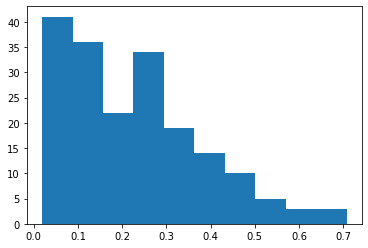

0.25579664059146
0.23154569703962607


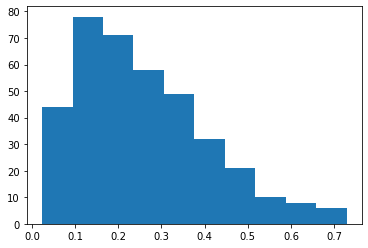

0.2777267779089313
0.2560207205859784


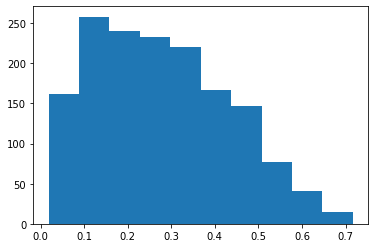

0.26985828573437987
0.24444421191766985


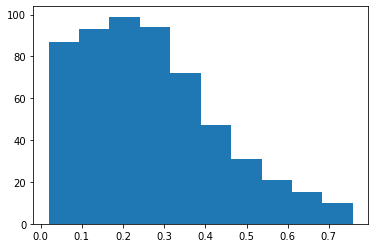

0.2136418244368919
0.18304965240584045


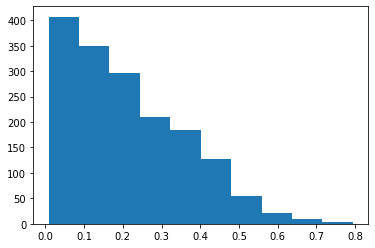

0.2557262412637924
0.22530441981339486


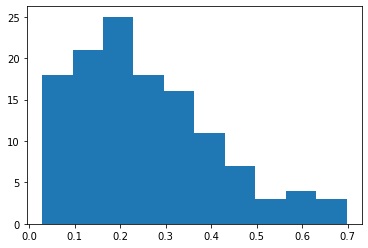

0.2721488718892587
0.24335915844693412


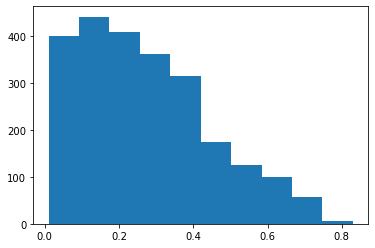

0.29071320887971114
0.27135986423119207


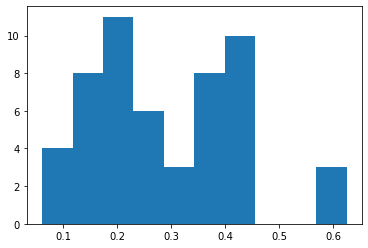

0.2737720435167229
0.23977645229954547


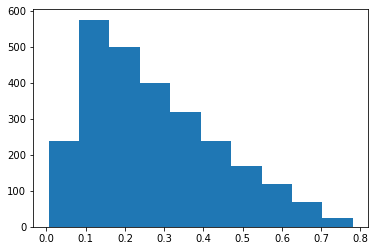

0.2586332369135265
0.23750073344154968


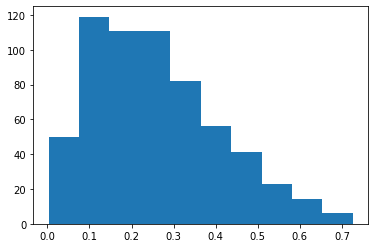

0.3277558928034345
0.2871626713151775


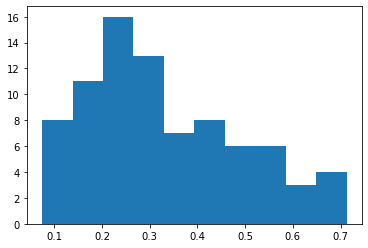

0.283724745432186
0.27492544443903333


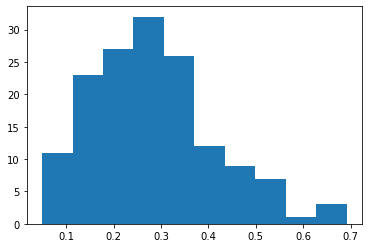

0.2613933002589412
0.245779478328978


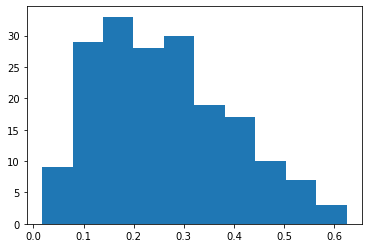

0.274286864961448
0.2514351250163958


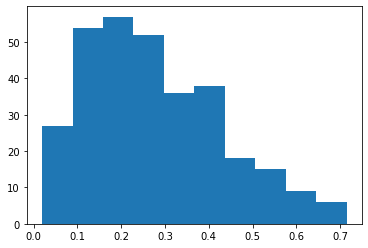

0.2696341324690945
0.23774540884267623


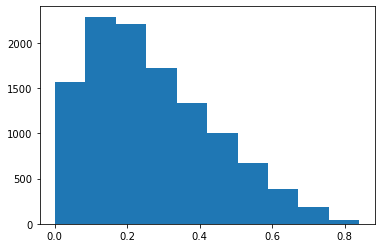

0.25815331989014456
0.23002952226139126


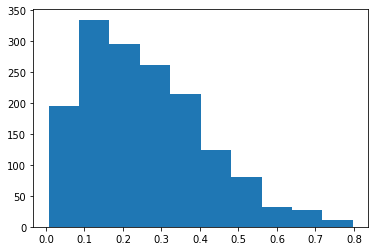

0.264533077727261
0.23899132398395512


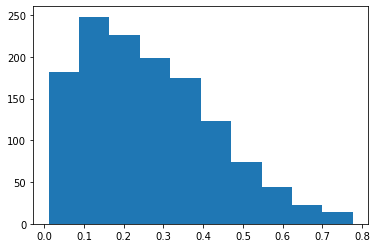

0.30179507558486096
0.31909229177641574


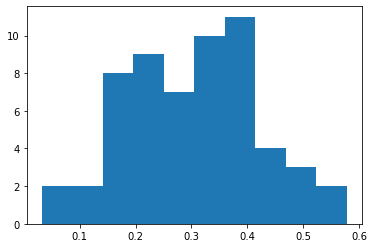

0.3317731438023625
0.3392009433949145


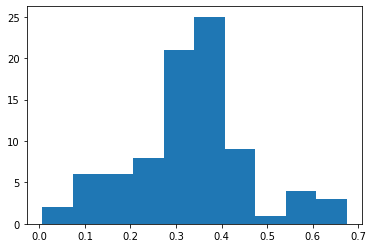

0.2548534612305715
0.22533677600395233


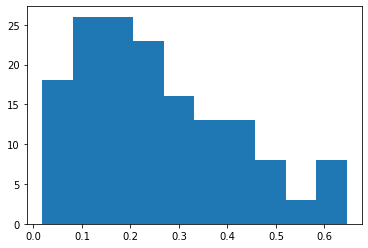

In [100]:
size_mat['8_8']
len(dist_mat['8_8'])

for i in range(20):
    plt.hist(dist_mat[f'{i}_{i}'])
    print(np.mean(dist_mat[f'{i}_{i}']))
    print(np.median(dist_mat[f'{i}_{i}']))
    plt.show()

0.17121668287270886

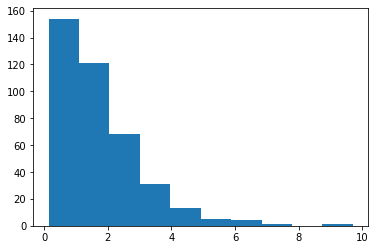

In [68]:
# object_sizes[0]['w']

idx = 3
# plt.hist(object_sizes[idx]['w'])
# plt.hist(object_sizes[idx]['h'])

plt.hist(np.array(object_sizes[idx]['w'])/np.array(object_sizes[idx]['h']),10)
np.mean(object_sizes[idx]['w'])
np.mean(object_sizes[idx]['h'])

# plt.hist(w_list)
# plt.hist(h_list)

In [33]:
np.random.randint(0, 123.2)

48

In [5]:
split = 'trainval'
all_labels = get_labels(split)
all_labels[:10]

5011it [00:01, 4673.10it/s]


[[8, 8, 8, 8, 8],
 [6],
 [12, 14, 14, 14],
 [6],
 [1],
 [14, 12],
 [7, 7],
 [6],
 [11, 14, 14, 14],
 [1, 1, 1, 14, 14, 14]]

In [6]:
mat = get_cooccurrence(all_labels, n_labels=20)
# print(np.array(mat))
print(mat)

[[187, 0, 0, 5, 0, 1, 21, 0, 1, 0, 0, 0, 0, 0, 86, 0, 6, 0, 0, 1], [0, 377, 0, 2, 7, 26, 77, 1, 54, 1, 1, 3, 0, 15, 1543, 28, 0, 8, 0, 8], [0, 0, 1560, 13, 0, 0, 6, 0, 8, 59, 0, 2, 0, 0, 235, 10, 0, 0, 0, 0], [5, 2, 13, 569, 0, 28, 99, 0, 8, 35, 3, 4, 0, 2, 280, 3, 0, 1, 1, 0], [0, 7, 0, 0, 1664, 3, 24, 8, 405, 1, 174, 15, 1, 0, 1305, 126, 6, 66, 0, 73], [1, 26, 0, 28, 3, 126, 292, 0, 0, 0, 0, 2, 0, 29, 524, 0, 0, 0, 1, 0], [21, 77, 6, 99, 24, 292, 2387, 4, 24, 22, 0, 10, 31, 201, 2263, 22, 15, 20, 41, 6], [0, 1, 0, 0, 8, 0, 4, 53, 49, 0, 7, 10, 0, 0, 42, 32, 0, 33, 0, 17], [1, 54, 8, 8, 405, 0, 24, 49, 2657, 0, 981, 54, 3, 4, 1998, 373, 0, 342, 0, 353], [0, 1, 59, 35, 1, 0, 22, 0, 0, 613, 0, 5, 43, 3, 182, 0, 6, 0, 0, 0], [0, 1, 0, 3, 174, 0, 0, 7, 981, 0, 82, 5, 0, 0, 713, 75, 0, 50, 0, 20], [0, 3, 2, 4, 15, 2, 10, 10, 54, 5, 5, 151, 14, 3, 315, 17, 31, 59, 0, 14], [0, 0, 0, 0, 1, 0, 31, 0, 3, 43, 0, 14, 185, 0, 784, 8, 8, 0, 2, 0], [0, 15, 0, 2, 0, 29, 201, 0, 4, 3, 0, 3, 0, 312, 11

In [7]:
split = 'test'
all_labels = get_labels(split)
mat = get_cooccurrence(all_labels, n_labels=20)

# save the cooccurrence matrix
f = open(f"./cooccurrence_matrix_voc07_{split}.json","w")
f.write(JSON.dumps(mat))
f.close()

4952it [00:01, 4655.84it/s]


### sanity check - if the code is working on some manual data

In [14]:
# code example, use testing set
# manually constructed sanity check examples 

# suppose we sequentially observe the following samples, how will the co-occurrence matrix change
all_labels = []

labels = [0,1,2]
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=3)
print(np.array(mat),'\n')

# in: [a,b,c]
# out:
#     [[0,1,1],
#      [1,0,1],
#      [1,1,0]]

# anomaly:
# victim a, anomaly [b,b,c], [c,b,c]
# victim b, anomaly [a,a,c], [a,c,c]
# victim c, anomaly [a,b,b]

    
labels = [0,0,1]
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=3)
print(np.array(mat),'\n')

# in: [a,a,b]
# out:
#     [[1,3,1],
#      [3,0,1],
#      [1,1,0]]
    
# victim a, anomaly [b,a,b]
# victim b, anomaly [a,a,c], [a,a,a]

    
labels = [0,0]models_bb
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=3)
print(np.array(mat),'\n')

# in: [a,a]
# out:
#     [[2,3,1],
#      [3,0,1],
#      [1,1,0]]

# victim a, anomaly [a,b], [a,c]
    
    
labels = [0,0,0,1]
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=3)
print(np.array(mat),'\n')

# in: [a,a,a,b]
# out: 
#     [[5,6,1],
#      [6,0,1],
#      [1,1,0]]

# victim a, anomaly [b,a,a,b], [c,a,a,b]
# victim b, anomaly [a,a,a,a], [a,a,a,c]
matrix = get_cooccurrence(all_labels, n_labels=3)

[[0 1 1]
 [1 0 1]
 [1 1 0]] 

[[1 3 1]
 [3 0 1]
 [1 1 0]] 

[[2 3 1]
 [3 0 1]
 [1 1 0]] 

[[5 6 1]
 [6 0 1]
 [1 1 0]] 



In [15]:

all_labels = []
# [a,b,c,x,y,z] : [0,1,2,3,4,5]

# [a,b]
labels = [0,1]
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=6)
print(np.array(mat),'\n')

# [a,c]
labels = [0,2]
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=6)
print(np.array(mat),'\n')

# [x,y]
labels = [3,4]
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=6)
print(np.array(mat),'\n')


# [x,z]
labels = [3,5]
all_labels.append(labels)
mat = get_cooccurrence(all_labels, n_labels=6)
print(np.array(mat),'\n')

[[0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] 

[[0 1 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] 

[[0 1 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]] 

[[0 1 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 1]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]] 



In [38]:
all_ = list(range(10))
combo = [0,1]
[all_[i] for i in combo]
[all_[i] for i in range(len(all_)) if i not in combo]

[2, 3, 4, 5, 6, 7, 8, 9]